In [90]:
#imports
import matplotlib.pyplot as plt
import astropy.io
from astropy.io import fits
from astropy import wcs
import numpy as np
from numpy import append
import healpy as hp
from cosmology import *
from scipy.interpolate import *
import pixell
from pixell import reproject, enplot, enmap, utils

In [2]:
# variables for Halo catalog
omegab = 0.049
omegac = 0.261
omegam = omegab + omegac
h      = 0.68
ns     = 0.965
sigma8 = 0.81
c = 3e5
H0 = 100*h
nz = 100000
z1 = 0.0
z2 = 6.0
za = np.linspace(z1,z2,nz)
dz = za[1]-za[0]
H = lambda z: H0*np.sqrt(omegam*(1+z)**3+1-omegam)
dchidz = lambda z: c/H(z)
chia = np.cumsum(dchidz(za))*dz
zofchi = interp1d(chia,za)
rho = 2.775e11*omegam*h**2 # Msun/Mpc^3d

In [3]:
# Opens fits files that aren't in alm form
def read_healpy_normal(file):
    return hp.read_map(file)

# Uses healpy to graph fits files that aren't in alm form
def display_healpy_normal(file): 
    return hp.gnomview(read_healpy_normal(file))

# Opens fits files that are in alm form
def read_healpy_alm(file):
    A1 = hp.read_alm(file)
    NSIDE1 = 1024
    return hp.alm2map(A1,NSIDE1)

# Uses healpy to graph fits files that are in alm form
def display_healpy_alm(file): 
    return hp.gnomview(read_healpy_alm(file))

In [4]:
# Converts to an enmap
def read_enmap_normal(file):
    shape, wcs = enmap.fullsky_geometry(res=0.5 * utils.arcmin, proj='car')
    iheal = read_healpy_normal(file)
    iheal = iheal.astype(np.float32)
    return reproject.healpix2map(iheal,shape,wcs)

# Graphs enmap using pixell
def display_enmap_normal(file):
    shape, wcs = enmap.fullsky_geometry(res=0.5 * utils.arcmin, proj='car')
    iheal = read_healpy_normal(file)
    iheal = iheal.astype(np.float32)
    enmap_map = reproject.healpix2map(iheal,shape,wcs)
    return plt.imshow(enmap_map)

# Converts to an enmap for alm files
def read_enmap_alm(file):
    shape, wcs = enmap.fullsky_geometry(res=0.5 * utils.arcmin, proj='car')
    iheal = read_healpy_alm(file)
    iheal = iheal.astype(np.float32)
    return reproject.healpix2map(iheal,shape,wcs)

# Graphs enmap using pixell for alm files
def display_enmap_alm(file):
    shape, wcs = enmap.fullsky_geometry(res=0.5 * utils.arcmin, proj='car')
    iheal = read_healpy_alm(file)
    iheal = iheal.astype(np.float32)
    enmap_map = reproject.healpix2map(iheal,shape,wcs)
    return plt.imshow(enmap_map)

In [5]:
#ONLY RUN ONCE

# Defines shape and wcs for a full sky projection
shape, wcs = enmap.fullsky_geometry(res=0.5 * utils.arcmin, proj='car')

# Creates a variable for the kappa enmap
iheal_kap = read_healpy_normal('kap.fits')
iheal_kap = iheal_kap.astype(np.float32)
enmap_map_kaps = reproject.healpix2map(iheal_kap,shape,wcs)

# Creates a variable for the tsz enmap
iheal_tsz = read_healpy_normal('tsz.fits')
iheal_tsz = iheal_tsz.astype(np.float32)
enmap_map_tsz = reproject.healpix2map(iheal_tsz,shape,wcs)

# Creates a variable for the lensed enmap
iheal_lensed = read_healpy_alm('lensed_alm.fits')
iheal_lensed = iheal_lensed.astype(np.float32)
enmap_map_lensed = reproject.healpix2map(iheal_lensed,shape,wcs)

In [135]:
# ONLY RUN ONCE
# Opens the first N terms in the Halos Catalog
f=open('halos.pksc')
N = 20000
catalog=np.fromfile(f,count=N*10,dtype=np.float32)

In [136]:
# Converts catalog data into a useful form
# Theta = colatitude, phi = longitude

catalog=np.reshape(catalog,(N,10))
x  = catalog[:,0];  y = catalog[:,1];  z = catalog[:,2] # Mpc (comoving)
vx = catalog[:,3]; vy = catalog[:,4]; vz = catalog[:,5] # km/sec
R  = catalog[:,6] # Mpc
M200m    = 4*np.pi/3.*rho*R**3        # this is M200m (mean density 200 times mean) in Msun
chi      = np.sqrt(x**2+y**2+z**2)    # Mpc
vrad     = (x*vx + y*vy + z*vz) / chi # km/sec
redshift = zofchi(chi)  
theta, phi  = hp.vec2ang(np.column_stack((x,y,z))) # in radians

In [49]:
# Converts colatitude and longitude into declination and right assencion
def read_halo(i):
    lat = np.pi/2 -theta
    return lat[i], phi[i]

In [9]:
# Lists coordinates and corresponing indices of clusters with large masses
def give_me_coords(j):
    big_mass_coords = []
    big_mass_j = []
    lat = np.pi/2 -theta
    for j in range(N):
        if M200m[j] >= 6*10**14:
            winners = lat[j], phi[j]
            big_mass_coords.append(winners)
            big_mass_j.append(j)
    return big_mass_coords, big_mass_j

In [10]:
# ONLY RUN ONCE
# Creates a thumbnail centered around given coordinates

def thumbnail_kap(i):
    coords = read_halo(i)
    return reproject.thumbnails(enmap_map_kaps,coords)

def thumbnail_tsz(i):
    coords = read_halo(i)
    return reproject.thumbnails(enmap_map_tsz,coords)

def thumbnail_lensed(i):
    coords = read_halo(i)
    return reproject.thumbnails(enmap_map_lensed,coords)

In [121]:
def averaged_map_kap(i):
    image_list_kap = []
    
    for z in range(i):
        image_list_kap.append(np.array(thumbnail_kap(z)))
        
    # Stack the images into a single NumPy array
    stacked_images_kap = np.stack(image_list_kap, axis=0)  # Stack along the first axis (0)
    
    # Compute the average of the stacked images
    average_image_kap = np.average(stacked_images_kap, axis=0)
    
    return average_image_kap
    
#     plt.imshow(average_image_kap)
    
def averaged_map_tsz(i):
    image_list_tsz = []

    for z in range(i):
        image_list_tsz.append(np.array(thumbnail_tsz(z)))
        
    # Stack the images into a single NumPy array
    stacked_images_tsz = np.stack(image_list_tsz, axis=0)  # Stack along the first axis (0)
    
    # Compute the average of the stacked images
    average_image_tsz = np.average(stacked_images_tsz, axis=0)
    
    return average_image_tsz
    
#     plt.imshow(average_image_tsz)
    
def averaged_map_lensed(i):
    image_list_lensed = []
    
    for z in range(i):
        image_list_lensed.append(np.array(thumbnail_lensed(z)))
        
    # Stack the images into a single NumPy array
    stacked_images_lensed = np.stack(image_list_lensed, axis=0)  # Stack along the first axis (0)
    
    # Compute the average of the stacked images
    average_image_lensed = np.average(stacked_images_lensed, axis=0)
    
    return average_image_lensed
    
#     plt.imshow(average_image_lensed)


In [123]:
# For any i indice, plots each data set as subplots
def averaged_subplots(i):
    average_map_kap = averaged_map_kap(i)
    average_map_tsz = averaged_map_tsz(i)
    average_map_lensed = averaged_map_lensed(i)
    fig, axs = plt.subplots(1, 3)
    im1 = axs[0].imshow(average_map_kap, origin='lower')
    cbar1 = fig.colorbar(im1, ax=axs[0], fraction=0.04, orientation='horizontal', pad=0.1)
    im2 = axs[1].imshow(average_map_tsz, origin='lower')
    cbar2 = fig.colorbar(im2, ax=axs[1], fraction=0.04, orientation='horizontal', pad=0.1)
    im3 = axs[2].imshow(average_map_lensed, origin='lower')
    cbar3 = fig.colorbar(im3, ax=axs[2], fraction=0.04, orientation='horizontal', pad=0.1)
    axs[0].set_title('Kappa')
    axs[1].set_title('Tsz')
    axs[2].set_title('Lensed Temp')
    return plt.show()

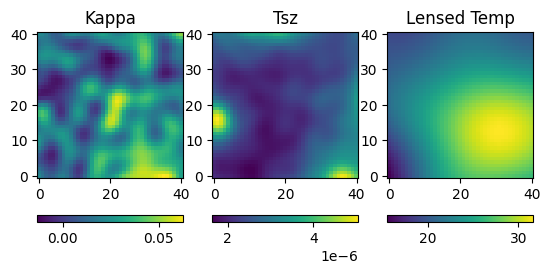

In [125]:
averaged_subplots(50)

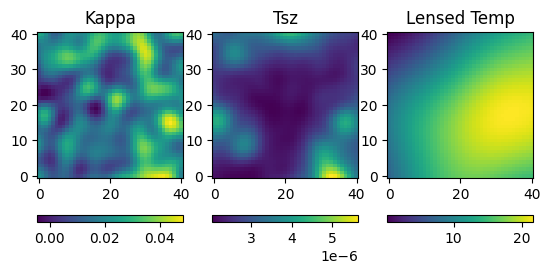

In [124]:
averaged_subplots(100)

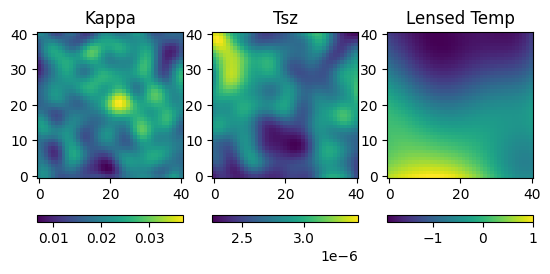

In [126]:
averaged_subplots(500)

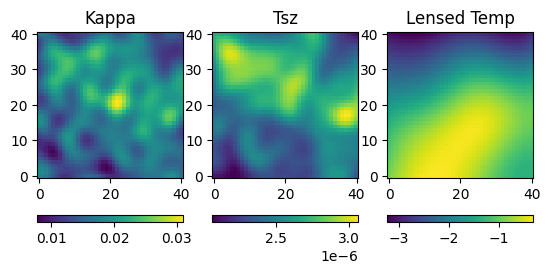

In [127]:
averaged_subplots(1000)

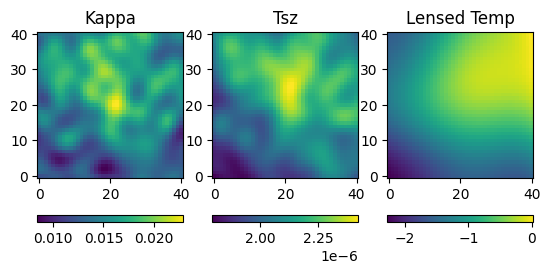

In [129]:
averaged_subplots(3000)

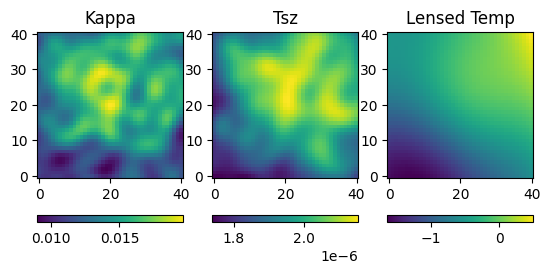

In [134]:
averaged_subplots(5000)

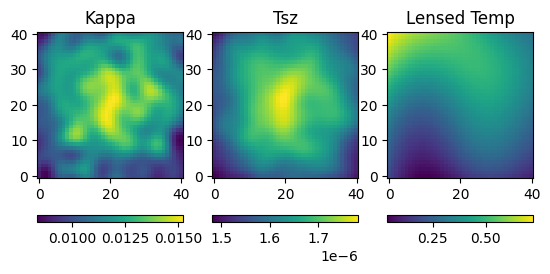

In [137]:
averaged_subplots(20000)

# Work Space

In [82]:
# For any i indice, plots each data set as subplots
def thumbnail_subplots(i):
    coords = read_halo(i)
    new_map_kap = reproject.thumbnails(enmap_map_kaps,coords)
    print(np.shape(new_map_kap))
    new_map_tsz = reproject.thumbnails(enmap_map_tsz,coords)
    new_map_lensed = reproject.thumbnails(enmap_map_lensed,coords)
    fig, axs = plt.subplots(1, 3)
    im1 = axs[0].imshow(new_map_kap, origin='lower')
    cbar1 = fig.colorbar(im1, ax=axs[0], fraction=0.04, orientation='horizontal', pad=0.1)
#     cbar1 = fig.colorbar(first, ax=axs, fraction=0.04, orientation='horizontal', pad=0.05)
    im2 = axs[1].imshow(new_map_tsz, origin='lower')
    cbar2 = fig.colorbar(im2, ax=axs[1], fraction=0.04, orientation='horizontal', pad=0.1)
#     cbar2 = fig.colorbar(second, ax=axs, fraction=0.04, orientation='horizontal', pad=0.05)
    im3 = axs[2].imshow(new_map_lensed, origin='lower')
    cbar3 = fig.colorbar(im3, ax=axs[2], fraction=0.04, orientation='horizontal', pad=0.1)
#     cbar3 = fig.colorbar(third, ax=axs, fraction=0.04, orientation='horizontal', pad=0.05)
    axs[0].set_title('Kappa')
    axs[1].set_title('Tsz')
    axs[2].set_title('Lensed Temp')
    return plt.show()

(41, 41)


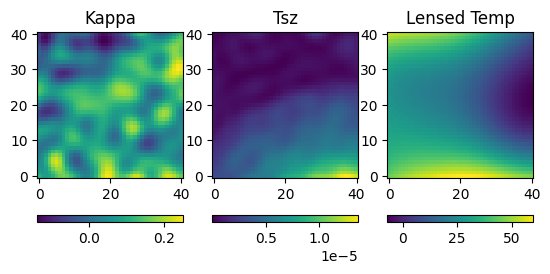

In [83]:
# Example 1 of a galaxy cluster with large mass
thumbnail_subplots(1)

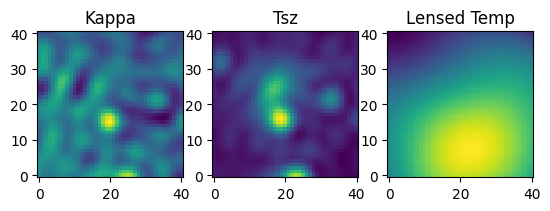

In [13]:
# Example 2 of a galaxy cluster with large mass
thumbnail_subplots(3)

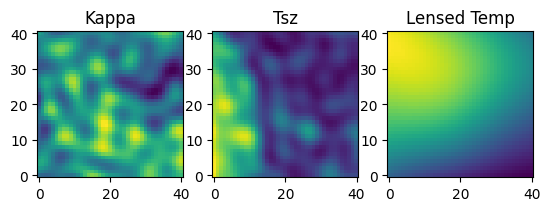

In [14]:
# Example 3 of a galaxy cluster with large mass
thumbnail_subplots(4)

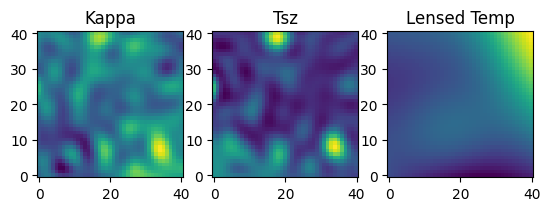

In [16]:
# Example 4 of a galaxy cluster with large mass
thumbnail_subplots(7)

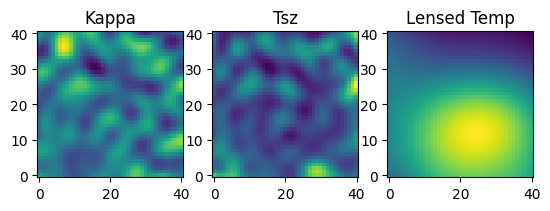

In [17]:
# Example 5 of a galaxy cluster with large mass
thumbnail_subplots(8)

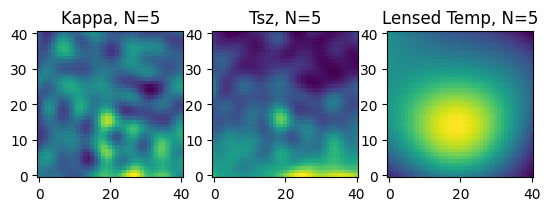

In [18]:
# Stacks thumbnails of examples 1-5
kap_composite = thumbnail_kap(1) + thumbnail_kap(3) + thumbnail_kap(4) + thumbnail_kap(7) + thumbnail_kap(8)
tsz_composite = thumbnail_tsz(1) + thumbnail_tsz(3) + thumbnail_tsz(4) + thumbnail_tsz(7) + thumbnail_tsz(8)
lensed_composite = thumbnail_lensed(1) + thumbnail_lensed(3) + thumbnail_lensed(4) + thumbnail_lensed(7) + thumbnail_lensed(8)

fig, axs = plt.subplots(1, 3)
axs[0].imshow(kap_composite, origin='lower')
axs[1].imshow(tsz_composite, origin='lower')
axs[2].imshow(lensed_composite, origin='lower')
axs[0].set_title('Kappa, N=5')
axs[1].set_title('Tsz, N=5')
axs[2].set_title('Lensed Temp, N=5')
plt.show()

In [59]:
def thumbnail_subplots_composite(N):
    for i in range(N-1):
        kap_composite = thumbnail_kap(i) +thumbnail_kap(i+1)
        tsz_composite = thumbnail_tsz(i) +thumbnail_tsz(i+1)
        lensed_composite = thumbnail_lensed(i) +thumbnail_lensed(i+1)
    
    fig, axs = plt.subplots(1, 3)
    im1_comp = axs[0].imshow(kap_composite, origin='lower')
    cbar1_comp = fig.colorbar(im1_comp, ax=axs[0], fraction=0.04, orientation='horizontal', pad=0.1)
    im2_comp = axs[1].imshow(tsz_composite, origin='lower')
    cbar2_comp = fig.colorbar(im2_comp, ax=axs[1], fraction=0.04, orientation='horizontal', pad=0.1)
    im3_comp = axs[2].imshow(lensed_composite, origin='lower')
    cbar3_comp = fig.colorbar(im3_comp, ax=axs[2], fraction=0.04, orientation='horizontal', pad=0.1)
    axs[0].set_title('Kappa')
    axs[1].set_title('Tsz')
    axs[2].set_title('Lensed Temp')
    plt.show()

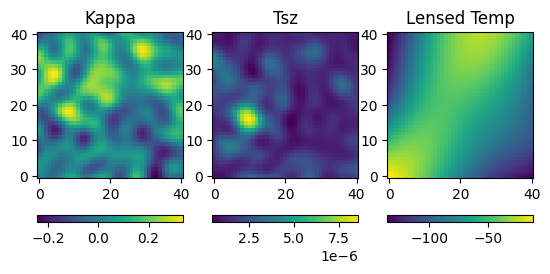

In [61]:
thumbnail_subplots_composite(100)

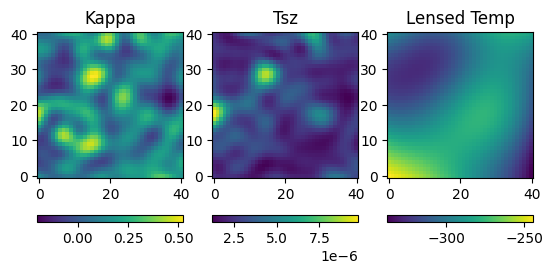

In [64]:
thumbnail_subplots_composite(150)

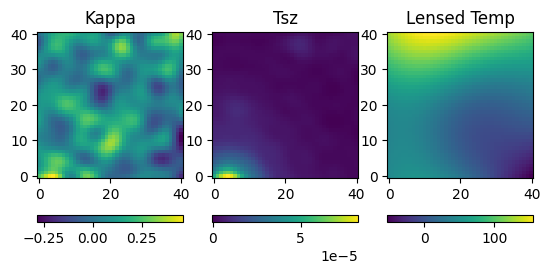

In [62]:
thumbnail_subplots_composite(200)

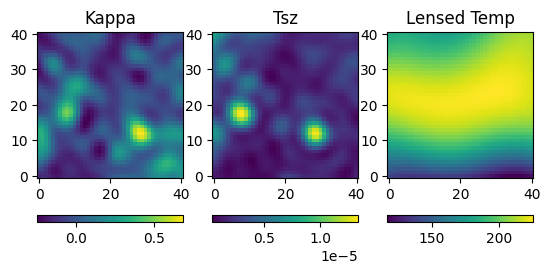

In [65]:
thumbnail_subplots_composite(250)

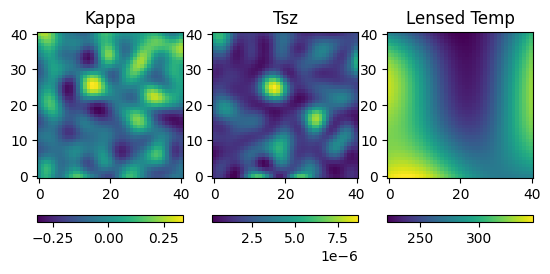

In [63]:
thumbnail_subplots_composite(300)